# Baseline performance
In this notebook, I analyze the results for the baseline HGS-VRPTW implementation by [1]. 

For each solved instance, there are three results files:
- `<inst>.txt` contains the final solution
- `<inst>.txt.PG.csv` contains the search progress for the incumbent solutions
- `<inst>.search.log` contains the entire search progress per 500 iterations

where `<inst>` denotes the instance name.

I ran the original baseline implementation for two different experiments:
1. 20K NoImprovement, timeLimit 7200s, no restart if time limit not reached, single seed
2. 50K NoImprovement, timeLimit 7200s, no restart if time limit not reached, single seed

The corresponding results can be found in the folder `data/baseline/20K` and `data/baseline/50K`, respectively.

In [135]:
from pathlib import Path
import os
import re

import numpy as np
import matplotlib.pyplot as plt

## Parsing functions

In [257]:
def readlines(path):
    with open(path, 'r') as fi:
        return fi.readlines()
    
def parse_solution(path):
    """
    Parse the solution file.
    """
    solution = []
    extra = {}
    
    for line in readlines(path):
        if "Route" in line:
            route = [int(cust) for cust in re.match(r"Route #\d+: (.*)", line).group(1).split()]
            solution.append(route)

        else:
            key, val = line.split()
            extra[key] = float(val)                

    return solution, extra

    
def parse_pg(path):
    """
    Parse the PG file.
    """
    times, costs = [], []
    
    for line in readlines(path):
        inst_path, seed, cost, time = line.strip().split(';')
        times.append(float(time))
        costs.append(int(cost))
        
    return np.array(times), np.array(costs)
    
def parse_search(path):
    flag = 0
    iters, times, costs = [], [], []

    for line in readlines(path):
        if line.startswith("----- STARTING"):
            flag = 1

        elif line.startswith("----- GENETIC ALGORITHM FINISHED"):
            flag = 0

        elif flag:
            data = [section.split() for section in line.split(" | ")][:3]
            data = {section[0]: section[1:] for section in data}

            iters.append(int(data["It"][0]))
            times.append(float(data["T(s)"][0]))
            
            if "Feas" in data:
                costs.append(float(data["Feas"][1]))
            else:
                costs.append(np.nan)
            
    return {'iters': np.array(iters), 'times': np.array(times), 'costs': np.array(costs)}

In [237]:
def instances():
    """Return instance names and ignore a few."""
    ignore = ['ORTEC-VRPTW-ASYM-2e2ef021-d1-n210-k17.txt', 'ORTEC-VRPTW-ASYM-00c5356f-d1-n258-k12.txt']
    inst_dir = Path('../instances')
    return [name for name in os.listdir(inst_dir) if name not in ignore]

In [238]:
def append(path, postfix):
    return path.with_name(f'{path.name}{postfix}')

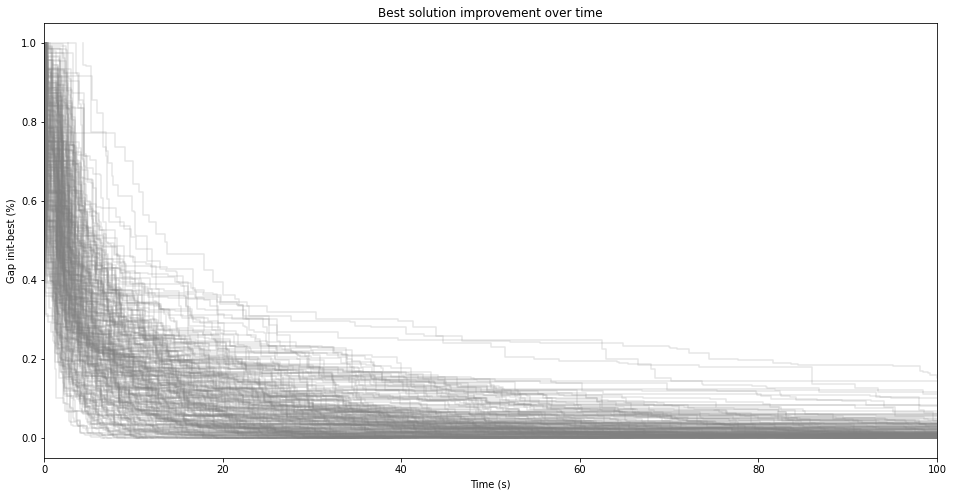

In [239]:
k20 = Path('../data/baseline/50K/0')

plt.figure(figsize=[16, 8])

for inst in instances():
    times, costs = parse_pg(append(k20 / inst, '.PG.csv'))
    
    max_gap = costs[0] - costs[-1]
    normalized_costs = (costs - costs[-1]) / max_gap
    
    plt.step(times, normalized_costs, alpha=0.2, color='grey')

plt.xlim(0, 100)
    
plt.title('Best solution improvement over time')
plt.xlabel('Time (s)')
plt.ylabel('Gap init-best (%)')
plt.show()

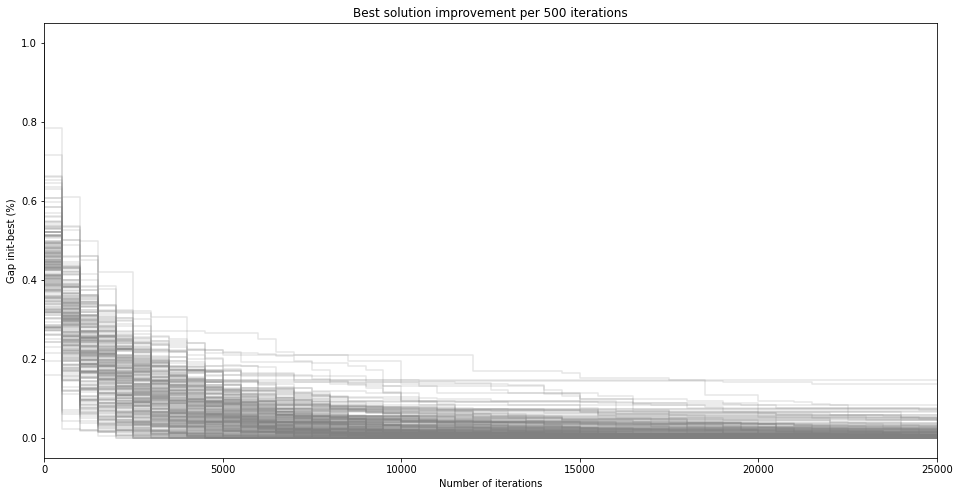

In [279]:
k20 = Path('../data/baseline/50K/0')

plt.figure(figsize=[16, 8])

for inst in instances():
    data = parse_search(append(k20 / inst, '.search.log'))
    iters, times, costs = data['iters'], data['times'], data['costs']
    np.nan_to_num(costs, copy=False, nan=np.max(costs)) # Replace infeasible with first feasible
    max_gap = costs[0] - costs[-1]
    normalized_costs = (costs - costs[-1]) / max_gap
    
    plt.step(iters, normalized_costs, alpha=0.2, color='grey')

plt.xlim(0, 25000)
    
plt.title('Best solution improvement per 500 iterations')
plt.xlabel('Number of iterations')
plt.ylabel('Gap init-best (%)')
plt.show()

In [259]:
costs

array([78631., 74027., 73455., 73082., 72748., 72748., 72274., 72274.,
       72274., 72107., 72107., 72015., 72015., 72015., 72015., 72015.,
       72015., 72015., 72015., 72015., 72015., 72015., 72015., 72015.,
       72015., 71664., 71664., 71664., 71664., 71664., 71640., 71522.,
       71522., 71522., 71522., 71522., 71485., 71485., 71162., 71162.,
       71162., 71045., 71045., 71019., 70978., 70954., 70801., 70801.,
       70801., 70744., 70744., 70744., 70744., 70725., 70725., 70725.,
       70725., 70725., 70725., 70725., 70706., 70602., 70602., 70602.,
       70602., 70602., 70602., 70602., 70602., 70593., 70593., 70593.,
       70593., 70593., 70552., 70455., 70404., 70364., 70358., 70345.,
       70345., 70343., 70343., 70343., 70338., 70338., 70338., 70338.,
       70338., 70318., 70318., 70318., 70318., 70318., 70318., 70318.,
       70318., 70318., 70318., 70318., 70318., 70318., 70318., 70318.,
       70318., 70318., 70318., 70318., 70318., 70318., 70318., 70318.,
      

## Final average

In [211]:
costs = []
sol_path = Path('../data/baseline/50K/0/')
sol_path = Path('../data/baseline/20K/')

for inst in instances():
    sol, extra = parse_solution(sol_path / inst)
    costs.append(extra['Cost'])

np.mean(costs)

164564.96774193548